In [13]:
import netCDF4 as nc
from wrf import getvar, ALL_TIMES
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from math import sqrt
import glob
from datetime import datetime
from matplotlib.cm import get_cmap
from netCDF4 import Dataset
import calendar
import datetime
from scipy.interpolate import interp1d


In [14]:
out_dir ='/Users/eliotperrin/Desktop/Travail de bachelor/WRF_outputs_VL'

# simuCONTROL = out_dir + '/wrfout_Helmos_d03_CONTROL_VL_3.nc'
simuCONTROL = out_dir + '/wrfout_Helmos_d03_DEMOTT_VL.nc'


CONTROL = Dataset(simuCONTROL)


### WRF constants
RA=287.15
RD=287.0
CP=1004.5
P1000MB=100000.0
EPS=0.622

#time = CONTROL.variables['Times']
wrf_time = np.arange(np.datetime64('2021-12-17T00:00'), np.datetime64('2021-12-19T00:01'),dtype='datetime64[m]')[::30]


presCNT = np.squeeze(CONTROL.variables['P'][:] + CONTROL.variables['PB'][:])
thetCNT = np.squeeze(CONTROL.variables['T'][:] + 300.0)
qvCNT = np.squeeze(CONTROL.variables['QVAPOR'][:])
tkCNT = ((presCNT / P1000MB)**(RD/CP) * thetCNT)
tvCNT = tkCNT * (EPS + qvCNT) / (EPS * (1. + qvCNT))
rhoCNT = presCNT/RA/tvCNT
lwcCNT = np.squeeze(CONTROL.variables['QCLOUD'][:] + CONTROL.variables['QRAIN'][:])*rhoCNT*10**3 #gm-3
zstagCNT = np.squeeze(getvar(CONTROL,"zstag",timeidx=ALL_TIMES))
zstagCNT = zstagCNT[:]
dzCNT = np.diff(zstagCNT,axis=1)

lwpCNT = np.nansum(lwcCNT*dzCNT,axis=1)


In [15]:
simuALLSIP = out_dir + '/wrfout_Helmos_d03_ALLSIP02_VL.nc'

ALLSIP = Dataset(simuALLSIP)

presCNT_allsip = np.squeeze(ALLSIP.variables['P'][:] + ALLSIP.variables['PB'][:])
thetCNT_allsip = np.squeeze(ALLSIP.variables['T'][:] + 300.0)
qvCNT_allsip = np.squeeze(ALLSIP.variables['QVAPOR'][:])
tkCNT_allsip = ((presCNT_allsip / P1000MB)**(RD/CP) * thetCNT_allsip)
tvCNT_allsip = tkCNT_allsip * (EPS + qvCNT_allsip) / (EPS * (1. + qvCNT_allsip))
rhoCNT_allsip = presCNT_allsip/RA/tvCNT_allsip
lwcCNT_allsip = np.squeeze(ALLSIP.variables['QCLOUD'][:] + ALLSIP.variables['QRAIN'][:])*rhoCNT_allsip*10**3 #gm-3
icncCNT_allsip = np.squeeze((ALLSIP.variables['QNICE'][:] + ALLSIP.variables['QNSNOW'][:] + ALLSIP.variables['QNGRAUPEL'][:]))*rhoCNT_allsip*10**-3 #L-1
zstagCNT_allsip = np.squeeze(getvar(ALLSIP,"zstag",timeidx=ALL_TIMES))
zstagCNT_allsip = zstagCNT_allsip[:]
dzCNT_allsip = np.diff(zstagCNT_allsip,axis=1)

lwpCNT_allsip = np.nansum(lwcCNT_allsip*dzCNT_allsip,axis=1)


In [16]:
i=0

LWP = []
TIME = []

f = '/Users/eliotperrin/Desktop/Travail de bachelor/WProf_data/*ZEN_LV1*'
for fn in sorted(glob.glob(f)):
   
    i=i+1
    
    if i >=0:
        
        ds=nc.Dataset(fn)
        
        ql=np.array(ds.variables['Liquid-water-path'][:])
        dt = [datetime.datetime.utcfromtimestamp(tt) for tt in ds.variables['Time']]
        
        LWP = np.append(LWP,ql)
        TIME = np.append(TIME,dt)
        
        del(ql); del(dt)

        
LWP = np.array(LWP)
TIME = np.array(TIME)


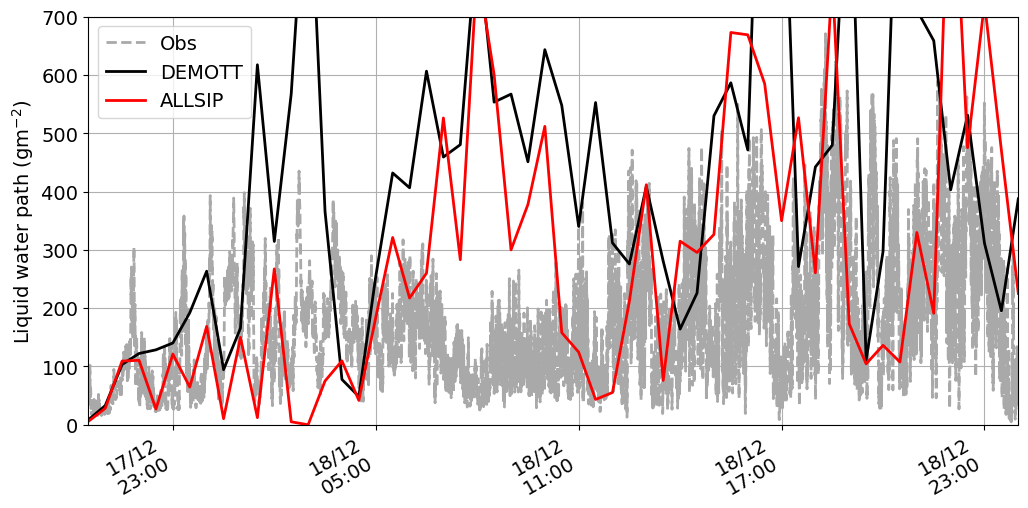

In [17]:
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=14)   # fontsize of the figure title

spin_up = 41
end = len(wrf_time)

fig, axs = plt.subplots(figsize=(12,6))

a = axs.plot(TIME,LWP,'--',color='darkgray', linewidth = 2, label='Obs')
b = axs.plot(wrf_time[spin_up:end],lwpCNT[spin_up:end],color='black', linewidth = 2, label='DEMOTT')
c = axs.plot(wrf_time[spin_up:end],lwpCNT_allsip[spin_up:end],color='r', linewidth = 2, label='ALLSIP')
axs.set_xlim(wrf_time[spin_up], wrf_time[end-1])
axs.set_ylabel(r'Liquid water path (gm$^{-2}$)')
axs.set_ylim(0,700)
xfmt = mdates.DateFormatter('%d/%m' +'\n'+ '%H:%M')
xlocator = mdates.MinuteLocator(interval = 360)
axs.xaxis.set_major_locator(xlocator)
axs.xaxis.set_major_formatter(xfmt)
fig.autofmt_xdate()
axs.legend()
axs.grid()

In [18]:
LWPCNT = np.array(lwpCNT[spin_up:end])
LWPCNT_allsip = np.array(lwpCNT_allsip[spin_up:end])

print(np.mean(LWP), "Moyennes WPROF", '+/-', np.std(LWP))
print(np.mean(LWPCNT), "Moyennes WPROF", '+/-', np.std(LWPCNT))
print(np.mean(LWPCNT_allsip), "Moyennes WPROF", '+/-', np.std(LWPCNT_allsip))

print(np.min(LWP),'#', np.max(LWP), 'Min et max')
print(np.min(LWPCNT),'#', np.max(LWPCNT), 'Min et max')
print(np.min(LWPCNT_allsip),'#', np.max(LWPCNT_allsip), 'Min et max')

print(np.median(LWP), 'Medianne')
print(np.median(LWPCNT), 'Medianne')
print(np.median(LWPCNT_allsip), 'Medianne')



91.72888442998362 Moyennes WPROF +/- 105.03103025946592
428.85693 Moyennes WPROF +/- 288.4352
277.31992 Moyennes WPROF +/- 238.78946
-2.9766921997070312 # 670.8836059570312 Min et max
8.429539 # 1330.7107 Min et max
1.2576627e-06 # 1064.2559 Min et max
42.060293197631836 Medianne
404.85983 Medianne
214.80087 Medianne


In [19]:
wrf_time = wrf_time[spin_up:end]
lwpCNT = lwpCNT[spin_up:end]
lwpCNT_allsip = lwpCNT_allsip[spin_up:end]
print(wrf_time)
print(len(wrf_time))
print(lwpCNT)
print(len(lwcCNT))

['2021-12-17T20:30' '2021-12-17T21:00' '2021-12-17T21:30'
 '2021-12-17T22:00' '2021-12-17T22:30' '2021-12-17T23:00'
 '2021-12-17T23:30' '2021-12-18T00:00' '2021-12-18T00:30'
 '2021-12-18T01:00' '2021-12-18T01:30' '2021-12-18T02:00'
 '2021-12-18T02:30' '2021-12-18T03:00' '2021-12-18T03:30'
 '2021-12-18T04:00' '2021-12-18T04:30' '2021-12-18T05:00'
 '2021-12-18T05:30' '2021-12-18T06:00' '2021-12-18T06:30'
 '2021-12-18T07:00' '2021-12-18T07:30' '2021-12-18T08:00'
 '2021-12-18T08:30' '2021-12-18T09:00' '2021-12-18T09:30'
 '2021-12-18T10:00' '2021-12-18T10:30' '2021-12-18T11:00'
 '2021-12-18T11:30' '2021-12-18T12:00' '2021-12-18T12:30'
 '2021-12-18T13:00' '2021-12-18T13:30' '2021-12-18T14:00'
 '2021-12-18T14:30' '2021-12-18T15:00' '2021-12-18T15:30'
 '2021-12-18T16:00' '2021-12-18T16:30' '2021-12-18T17:00'
 '2021-12-18T17:30' '2021-12-18T18:00' '2021-12-18T18:30'
 '2021-12-18T19:00' '2021-12-18T19:30' '2021-12-18T20:00'
 '2021-12-18T20:30' '2021-12-18T21:00' '2021-12-18T21:30'
 '2021-12-18T2

In [20]:
"""
def toTimestamp(d):
  return calendar.timegm(d.timetuple())

def timetotimestamp(time):
  new_time = []
  for i in time:
    i = toTimestamp(i)
    new_time.append(i)
  return np.array(new_time)

def wrftimetotimestamp(time):
  new_time = []
  for i in time:
    i = i.astype(datetime.datetime)
    i = calendar.timegm(i.utctimetuple())
    new_time.append(i)
  return np.array(new_time)

"""


#time = CONTROL.variables['Times']
wrf_time = np.arange(np.datetime64('2021-12-17T00:00:00'), np.datetime64('2021-12-19T00:30:00'),dtype='datetime64[s]')[::30*60]

spin_up = 41  #this is the time that we remove until the model has reached an equilibrium and we can trust its results
end = len(wrf_time)
wrf_time = wrf_time[spin_up:end]


# Create datetime64 array with 1-second resolution
radar_time = np.array(TIME, dtype='datetime64[s]')

# Convert datetime64 arrays to float arrays
radar_time_float = radar_time.astype('float')
wrf_time_float = wrf_time.astype('float')

# Interpolate the radar data onto the temperature time array
interp_func = interp1d(radar_time_float, LWP,kind='linear', fill_value='extrapolate')

#Les datas sont interpollés à la résolution de wrf
interp_LWP_data = interp_func(wrf_time_float )

print(radar_time_float)
print(100*'*')
print(len(wrf_time))
print(wrf_time)
print(100*'*')
print(len(interp_LWP_data))
print(len(lwcCNT))

[1.63969920e+09 1.63969921e+09 1.63969921e+09 ... 1.63995839e+09
 1.63995839e+09 1.63995840e+09]
****************************************************************************************************
56
['2021-12-17T20:30:00' '2021-12-17T21:00:00' '2021-12-17T21:30:00'
 '2021-12-17T22:00:00' '2021-12-17T22:30:00' '2021-12-17T23:00:00'
 '2021-12-17T23:30:00' '2021-12-18T00:00:00' '2021-12-18T00:30:00'
 '2021-12-18T01:00:00' '2021-12-18T01:30:00' '2021-12-18T02:00:00'
 '2021-12-18T02:30:00' '2021-12-18T03:00:00' '2021-12-18T03:30:00'
 '2021-12-18T04:00:00' '2021-12-18T04:30:00' '2021-12-18T05:00:00'
 '2021-12-18T05:30:00' '2021-12-18T06:00:00' '2021-12-18T06:30:00'
 '2021-12-18T07:00:00' '2021-12-18T07:30:00' '2021-12-18T08:00:00'
 '2021-12-18T08:30:00' '2021-12-18T09:00:00' '2021-12-18T09:30:00'
 '2021-12-18T10:00:00' '2021-12-18T10:30:00' '2021-12-18T11:00:00'
 '2021-12-18T11:30:00' '2021-12-18T12:00:00' '2021-12-18T12:30:00'
 '2021-12-18T13:00:00' '2021-12-18T13:30:00' '2021-12-18T14:00

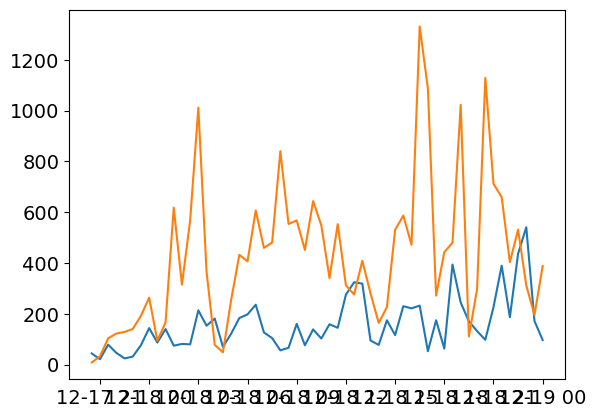

In [21]:
plt.plot(wrf_time,interp_LWP_data)
plt.plot(wrf_time,lwpCNT)

Text(0, 0.5, 'LWP from DEMOTT (gm$^{-2}$)')

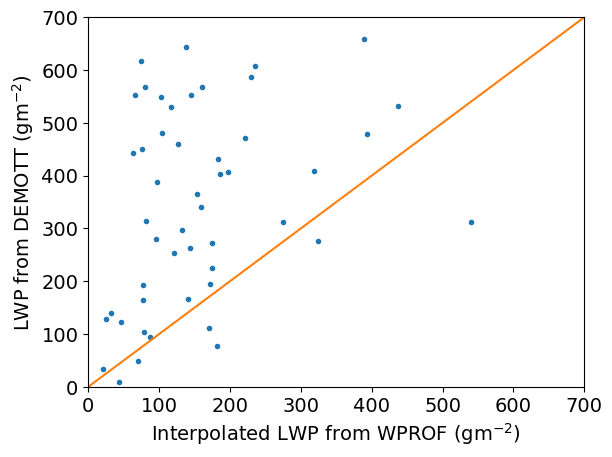

In [22]:
line = np.arange(700)

plt.plot(interp_LWP_data, lwpCNT, '.')
plt.plot(line, line)

plt.xlim(0, 700)
plt.ylim(0, 700)

plt.xlabel(r'Interpolated LWP from WPROF (gm$^{-2}$)')
plt.ylabel(r'LWP from DEMOTT (gm$^{-2}$)')


Text(0, 0.5, 'LWP from ALLSIP (gm$^{-2}$)')

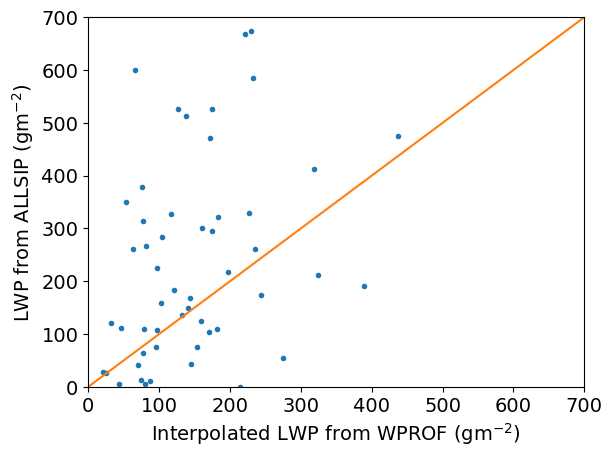

In [23]:
line = np.arange(700)

plt.plot(interp_LWP_data, lwpCNT_allsip, '.')
plt.plot(line, line )

plt.xlim(0, 700)
plt.ylim(0, 700)

plt.xlabel(r'Interpolated LWP from WPROF (gm$^{-2}$)')
plt.ylabel(r'LWP from ALLSIP (gm$^{-2}$)')

42.060293197631836
404.8598327636719
214.80087280273438


/Users/eliotperrin/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


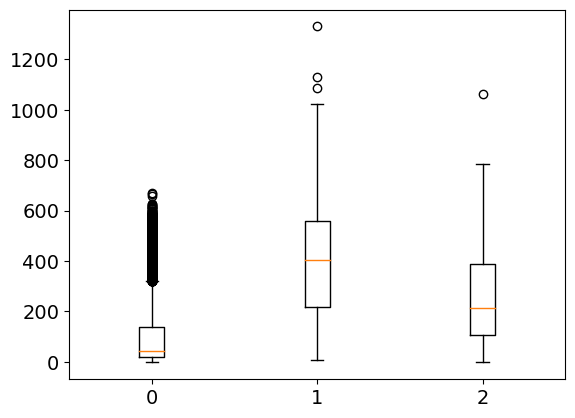

In [24]:
plt.figure()

box1 = plt.boxplot(LWP, positions=[0])

box2 = plt.boxplot(lwpCNT, positions=[1])

box3 = plt.boxplot(lwpCNT_allsip, positions=[2])

plt.xlim(-0.5, 2.5)

print(np.nanmedian(LWP))
print(np.nanmedian(lwpCNT))
print(np.nanmedian(lwpCNT_allsip))